In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
import datetime
%matplotlib inline 
plt.rc("font", family = "Malgun Gothic")
sns.set(font="Malgun Gothic", 
rc={"axes.unicode_minus":False}, style='darkgrid')

import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False

In [57]:
uir_df = pd.read_csv('./공모전/uir_df.csv', index_col = 0)
user = pd.read_csv('./공모전/LPOINT_BIG_COMP_01_DEMO.csv',index_col = 0)
product = pd.read_csv('./공모전/uir.csv',index_col = 0)

C:\Users\user\AppData\Local\Temp\ipykernel_1268\16780904.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  pdde = pd.read_csv('./공모전/LPOINT_BIG_COMP_02_PDDE.csv')


In [58]:
user.head(3)

,ma_fem_dv,ages,zon_hlv
cust,,,
M000034966,여성,40대,Z07
M000059535,여성,30대,Z12
M000136117,여성,30대,Z11


In [59]:
product.head(3)

,cust,pd_c,pd_nm,rct_no
0,M000034966,PD0116,김자반/부각/튀각,1
1,M000034966,PD0169,배,1
2,M000034966,PD0178,포도,1


In [60]:
uir_df.head(3)

,cust,pd_c,rct_no
0,M000034966,PD0116,1
1,M000034966,PD0169,1
2,M000034966,PD0178,1


In [61]:
uir_df['cust'].unique()

array(['M000034966', 'M000136117', 'M000201112', ..., 'M999770689',
       'M999849895', 'M999962961'], dtype=object)

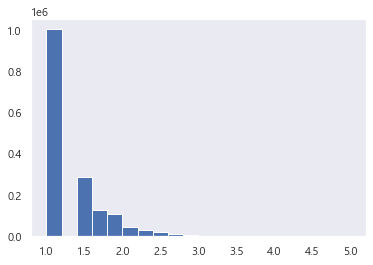

In [62]:
uir_df['Rating'] = uir_df['rct_no'].apply(lambda x: np.log10(x)+1)
uir_df['Rating'] = ((uir_df['Rating']- uir_df['Rating'].min()) / (uir_df['Rating'].max() - uir_df['Rating'].min()) * 4) + 1
uir_df['Rating'].hist(bins=20, grid=False)
uir_df = uir_df[['cust','pd_c','Rating']]
ratings = uir_df

In [63]:
ratings

,cust,pd_c,Rating
0,M000034966,PD0116,1.000000
1,M000034966,PD0169,1.000000
2,M000034966,PD0178,1.000000
3,M000034966,PD0204,1.000000
4,M000034966,PD0218,1.405571
...,...,...,...
1637596,M999962961,PD1857,1.000000
1637597,M999962961,PD1889,1.405571
1637598,M999962961,PD1896,1.000000
1637599,M999962961,PD1918,1.000000


In [64]:
from sklearn.model_selection import train_test_split

In [65]:
x = ratings.copy() # 원본 보존을 위해, copy()사용
y = ratings['cust'] # user_id기준으로 train set과 test set분리
# 75%는 train, 25%는 test y_train, y_test에는 사용자 id가 저장
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25)

In [66]:
x_train

,cust,pd_c,Rating
586881,M354104680,PD0675,1.000000
295626,M176877702,PD0640,1.000000
1546726,M940678331,PD0155,1.405571
663444,M399525065,PD1429,1.000000
1369339,M830687920,PD1825,1.000000
...,...,...,...
229217,M138020683,PD0379,1.642815
930561,M562512968,PD1388,2.138582
751629,M454845732,PD1505,2.347278
778492,M470112503,PD1820,1.000000


In [67]:
# 정확도(RMSE)를 계산하는 함수
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

# 모델별 정확도(RMSE)를 계산하는 함수
def score(model, neighbor_size=0):
    # 예측 대상인 test set에 있는 사용자(user_id)와 영화(movie_id)를 pair로 짝을 맞춰 데이터를 만든다
    id_pairs = zip(x_test['cust'], x_test['cust'])
    
    # 모든 사용자-영화 짝에 대해서 주어진 예측 모델(model)에 의한 예측값을 계산해서 y_pred에 리스트로 저장
    y_pred = np.array([model(cust,pd_c, neighbor_size) for (cust, pd_c) in id_pairs])
    
    # 실제 평점값 리스트를 x_test에서 받아옴
    y_true = np.array(x_test['Rating'])
    
    return RMSE(y_true, y_pred) # 얻어진 예측값 리스트와 실제값 리스트에 대한 RMSE를 계산해서 넘김

In [68]:
x_train

,cust,pd_c,Rating
586881,M354104680,PD0675,1.000000
295626,M176877702,PD0640,1.000000
1546726,M940678331,PD0155,1.405571
663444,M399525065,PD1429,1.000000
1369339,M830687920,PD1825,1.000000
...,...,...,...
229217,M138020683,PD0379,1.642815
930561,M562512968,PD1388,2.138582
751629,M454845732,PD1505,2.347278
778492,M470112503,PD1820,1.000000


In [69]:
# train 데이터로 Full matrix 구하기, 이 full matrix는 추천 알고리즘에서 사용
rating_matrix = x_train.pivot(index = 'cust', columns = 'pd_c', values ='Rating')
rating_matrix

pd_c,PD0001,PD0002,PD0003,PD0004,PD0005,PD0006,PD0007,PD0008,PD0009,PD0010,...,PD1924,PD1925,PD1926,PD1927,PD1928,PD1929,PD1930,PD1931,PD1932,PD1933
cust,,,,,,,,,,,,,,,,,,,,,
M000034966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M000136117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M000201112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M000225114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
M000261625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.642815,NaN,1.405571,NaN,NaN,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M999599111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M999673157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M999770689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
from sklearn.metrics.pairwise import cosine_similarity # cosine유사도 모듈을 가져옴

In [71]:
matrix_dummy = rating_matrix.copy().fillna(0) # 코사인 유사도 계산시에 NaN값이 있으면 에러가 발생하므로, NaN을 0으로 바꿔줌

user_similarity = cosine_similarity(matrix_dummy, matrix_dummy) # 실행시엔 대각선이 1.0인(자기 자신과의 유사도) 대칭 매트릭스임을 볼 수 있음

user_similarity = pd.DataFrame(user_similarity, index =rating_matrix.index, columns=rating_matrix.index)
user_similarity

cust,M000034966,M000136117,M000201112,M000225114,M000261625,M000350564,M000419293,M000494848,M000504230,M000508243,...,M999340261,M999441814,M999468256,M999492154,M999515910,M999599111,M999673157,M999770689,M999849895,M999962961
cust,,,,,,,,,,,,,,,,,,,,,
M000034966,1.000000,0.033565,0.113538,0.042446,0.000000,0.000000,0.000000,0.127062,0.128576,0.086101,...,0.0,0.000000,0.065603,0.000000,0.166322,0.053972,0.000000,0.102005,0.123577,0.090536
M000136117,0.033565,1.000000,0.033786,0.076695,0.218411,0.026945,0.189006,0.090283,0.022711,0.061634,...,0.0,0.000000,0.083687,0.183771,0.164749,0.027487,0.036025,0.031548,0.056445,0.117243
M000201112,0.113538,0.033786,1.000000,0.030026,0.000000,0.000000,0.000000,0.018740,0.171509,0.000000,...,0.0,0.000000,0.000000,0.000000,0.155973,0.054326,0.071202,0.219329,0.079370,0.147432
M000225114,0.042446,0.076695,0.030026,1.000000,0.204734,0.000000,0.297235,0.262718,0.245586,0.027387,...,0.0,0.000000,0.150886,0.000000,0.247598,0.144628,0.073928,0.218331,0.237489,0.137845
M000261625,0.000000,0.218411,0.000000,0.204734,1.000000,0.000000,0.260103,0.150104,0.063276,0.038721,...,0.0,0.000000,0.077563,0.000000,0.082391,0.048544,0.130327,0.087620,0.112371,0.083037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M999599111,0.053972,0.027487,0.054326,0.144628,0.048544,0.000000,0.096953,0.143426,0.150861,0.049552,...,0.0,0.000000,0.105065,0.000000,0.201104,1.000000,0.194931,0.159342,0.142239,0.092206
M999673157,0.000000,0.036025,0.071202,0.073928,0.130327,0.000000,0.108719,0.019982,0.062305,0.064945,...,0.0,0.000000,0.000000,0.000000,0.072636,0.194931,1.000000,0.000000,0.209451,0.000000
M999770689,0.102005,0.031548,0.219329,0.218331,0.087620,0.000000,0.118935,0.238446,0.227383,0.046459,...,0.0,0.041138,0.165756,0.000000,0.332265,0.159342,0.000000,1.000000,0.210636,0.242509


In [72]:
# Neighbor size를 정해서 예측치를 계산하는 함수
def cf_knn(cust, pd_c, neighbor_size = 0):
    if pd_c in rating_matrix:
        sim_scores = user_similarity[cust].copy()  # 주어진 사용자에 대한 유사도를 복사해서 가져옴
        
        pd_ratings = rating_matrix[pd_c].copy() # 주어진 영화에 대한 평점을 복사해서 가져옴
        
        # 주어진 영화에 대해서 평가를 하지 않은 사용자의 인덱스를 확인, 이 사람들에 대해서는 가중평균 계산에서 뺄거,,,
        none_rating_idx = pd_ratings[pd_ratings.isnull()].index 
        
        pd_ratings = pd_ratings.drop(none_rating_idx) # 주어진 영화에 대한 평점 중에서 평가하지 않은 사람의 평점(NaN)을 제거
        
        # 주어진 영화를 평가하지 않은 사용자와의 유사도를 제거, 가중평균시 계산에 필요가 없기 때문
        sim_scores = sim_scores.drop(none_rating_idx)
        
        # Neighbor size가 지정되지 않은 경우
        if neighbor_size == 0:
            
            # 주어진 영화에 대해서 평가한 각 사용자에 대해서 평점을 유사도로 가중평균한 예측치를 구함
            mean_rating = np.dot(sim_scores, pd_ratings) / sim_scores.sum()
            
        # Neighbor size가 지정된 경우
        else:
            if len(sim_scores) > 1:
                """
                이 조건을 넣는 이유는 경우에 따라서 해당 영화를 평가한 다른 사용자 수가 매우 작으면 계산에 문제가 생기기
                때문에 평가자 수가 최소 2명 이상인 경우만 그 다음 계산을 진행하도록 하기 위함
                """
                neighbor_size = min(neighbor_size, len(sim_scores))
                """
                지정된 neighbor_size값과 해당 영화를 평가한 총 사용자 수 중에서 작은 것을 이웃크기로 설정, 이 코드가 필요한
                이유는 경우에 따라서 유사도 계산이 가능한 이웃의 수가 지정된 neighbor_size값보다 작을 수도 있기 때문..
                """
                sim_scores = np.array(sim_scores) # 현재 sim_scores는 pandas인데, argsort를 적용하기 위해 numpy array로 바꿔줌
                
                pd_ratings = np.array(pd_ratings) # 역시 numpy array로 바꿔줌
                
                user_idx = np.argsort(sim_scores) # 다른 사용자를 유사도 순서대로 정렬
                
                sim_scores = sim_scores[user_idx][-neighbor_size:] # 가장 유사도가 높은 K명의 사용자를 선정
                
                pd_ratings = pd_ratings[user_idx][-neighbor_size:] # 선정된 k명의 사용자의 주어진 영화(movie_id)에 대한 평점 추출
                
                mean_rating = np.dot(sim_scores, pd_ratings) / sim_scores.sum()
                """
                선정된 k명의 이웃 사용자의 해당 영화에 대한 평점을 유사도로 가중한 평점평균을 구한다.
                """
            else:
                mean_rating = 3.0
    else:
        mean_rating = 3.0
        
    return mean_rating

In [73]:
score(cf_knn, neighbor_size = 30)

1.7767794005086175

In [74]:
cf_knn('M000034966', 'PD0169')

1.1665962628874154

In [59]:
ratings

,cust,pd_c,Rating
0,M000034966,PD0116,1.000000
1,M000034966,PD0169,1.000000
2,M000034966,PD0178,1.000000
3,M000034966,PD0204,1.000000
4,M000034966,PD0218,1.405571
...,...,...,...
1637596,M999962961,PD1857,1.000000
1637597,M999962961,PD1889,1.405571
1637598,M999962961,PD1896,1.000000
1637599,M999962961,PD1918,1.000000


In [20]:
# 주어진 사용자에 대해 추천받기
## 전체 데이터로 full matrix와 cosine similarity구하기
rating_matrix = ratings.pivot_table(values = 'Rating', index = 'cust', columns = 'pd_c')
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)
# 실제 추천을 할때에는 train/test set을 나눌 필요가 없기 때문에 전체 데이터를 사용해서 full matrix와 사용자 간 유사도(user_similarity)를 구한다

In [21]:
rating_matrix

pd_c,PD0001,PD0002,PD0003,PD0004,PD0005,PD0006,PD0007,PD0008,PD0009,PD0010,...,PD1924,PD1925,PD1926,PD1927,PD1928,PD1929,PD1930,PD1931,PD1932,PD1933
cust,,,,,,,,,,,,,,,,,,,,,
M000034966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M000136117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M000201112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M000225114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,1.0,NaN,NaN
M000261625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.642815,NaN,1.405571,NaN,1.642815,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M999599111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M999673157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M999770689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
user_similarity

cust,M000034966,M000136117,M000201112,M000225114,M000261625,M000350564,M000419293,M000494848,M000504230,M000508243,...,M999340261,M999441814,M999468256,M999492154,M999515910,M999599111,M999673157,M999770689,M999849895,M999962961
cust,,,,,,,,,,,,,,,,,,,,,
M000034966,1.000000,0.089166,0.083423,0.135189,0.041910,0.000000,0.066654,0.141109,0.248263,0.083646,...,0.000000,0.000000,0.136896,0.00000,0.197687,0.081472,0.000000,0.116134,0.151037,0.166180
M000136117,0.089166,1.000000,0.025496,0.149411,0.216120,0.050453,0.236948,0.152685,0.076293,0.061497,...,0.060857,0.000000,0.081386,0.16017,0.175602,0.042615,0.063104,0.087747,0.057335,0.153233
M000201112,0.083423,0.025496,1.000000,0.064716,0.000000,0.000000,0.000000,0.147416,0.270836,0.040249,...,0.000000,0.084715,0.033214,0.00000,0.242672,0.083673,0.103012,0.264919,0.088615,0.184801
M000225114,0.135189,0.149411,0.064716,1.000000,0.260146,0.057081,0.222996,0.340762,0.256235,0.017344,...,0.000000,0.000000,0.110661,0.00000,0.266488,0.161694,0.051250,0.260799,0.280053,0.239761
M000261625,0.041910,0.216120,0.000000,0.260146,1.000000,0.110828,0.217862,0.209174,0.045752,0.024320,...,0.000000,0.000000,0.084628,0.00000,0.062164,0.035532,0.089607,0.113609,0.126667,0.164779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M999599111,0.081472,0.042615,0.083673,0.161694,0.035532,0.000000,0.070257,0.189290,0.183081,0.033636,...,0.000000,0.000000,0.149369,0.00000,0.184917,1.000000,0.144850,0.187654,0.168137,0.228625
M999673157,0.000000,0.063104,0.103012,0.051250,0.089607,0.000000,0.074004,0.060509,0.088506,0.041411,...,0.000000,0.000000,0.000000,0.00000,0.130627,0.144850,1.000000,0.165821,0.230746,0.020223
M999770689,0.116134,0.087747,0.264919,0.260799,0.113609,0.013015,0.118131,0.345937,0.292688,0.043290,...,0.000000,0.026775,0.166292,0.00000,0.404881,0.187654,0.165821,1.000000,0.249902,0.261008


In [73]:
product

,cust,pd_c,pd_nm,rct_no
0,M000034966,PD0116,김자반/부각/튀각,1
1,M000034966,PD0169,배,1
2,M000034966,PD0178,포도,1
3,M000034966,PD0204,파인애플,1
4,M000034966,PD0218,쿠키,2
...,...,...,...,...
1637596,M999962961,PD1857,샴푸,1
1637597,M999962961,PD1889,BB/파운데이션/컴팩트류,2
1637598,M999962961,PD1896,립글로즈/틴트,1
1637599,M999962961,PD1918,페이셜클렌저,1


In [75]:
#  최적의 neighbor_size 구하기
for neighbor_size in [10,20,30,40,50,60]:
    print(f"Neighbor size = {neighbor_size} : RMSE = {score(cf_knn, neighbor_size)}")
# 40이 최적인듯?

Neighbor size = 10 : RMSE = 1.7767794005086175
Neighbor size = 20 : RMSE = 1.7767794005086175
Neighbor size = 30 : RMSE = 1.7767794005086175
Neighbor size = 40 : RMSE = 1.7767794005086175
Neighbor size = 50 : RMSE = 1.7767794005086175
Neighbor size = 60 : RMSE = 1.7767794005086175


In [76]:

def recommender(cust, n_items=10, neighbor_size = 20):
    """
    사용자 ID, 추천 아이템 수, 이웃 크기를 넘겨 받아서 주어진 사용자에 대한 아이템을 돌려주는 함수, 추천받을 영화의 수는 10,
    이웃의 크기는 20을 기본값으로 함
    """
    predictions = []
    # 예상 평점을 저장할 predictions를 초기화함
    
    rated_index = rating_matrix.loc[cust][rating_matrix.loc[cust] > 0].index
    # 현 사용자가 이미 평가한 영화를 표시(추천에서 제외하기 위함)
    
    items = rating_matrix.loc[cust].drop(rated_index)
    # 이미 평가한 영화는 대상에서 제외 > 안본 영화만 추천할 거
    
    for item in items.index: # 각 아이템에 대한 현 사용자의 예상 평점을 계산
        """
        cf_knn 함수를 호출해서 현재 사용자의 현재 아이템에 대한 예상 평점을 구해서 prediction에 추가,
        k명의 이웃 사용자의 해당 영화에 대한 평점을 유사도로 가중한 평점평균을 구함
        """
        predictions.append(cf_knn(cust,item, neighbor_size))
        
    # 예상 평점을 Series로 변환    
    recommendations = pd.Series(data=predictions, index=items.index, dtype=float)
    
    # recommendation에서 예상평점이 높은 순서로 정렬해서 주어진 아이템 수(n_items) 만큼 추천할 영화를 뽑아냄
    recommendations = recommendations.sort_values(ascending=False)[:n_items]
    
    #recommended_items = product.loc[recommendations.index]['pd_nm']
    rd = []
    for i in range(n_items):
        rd.append(product[product['pd_c'] == recommendations.index.values[i]]['pd_nm'])
    
    return rd

In [77]:
recommender(cust= 'M000034966', n_items=5, neighbor_size = 30) # 2번 사용자에 대해서 5개의 영화를 추천받는다. 이웃의 크기는 30

[351035    농구복
 Name: pd_nm, dtype: object,
 604105     바디패치/팩
 674614     바디패치/팩
 955258     바디패치/팩
 1286555    바디패치/팩
 Name: pd_nm, dtype: object,
 224192    하이앤드
 Name: pd_nm, dtype: object,
 1226651    반짇고리/세트
 Name: pd_nm, dtype: object,
 1260412    기타광학기기
 Name: pd_nm, dtype: object]

### 아이템기반 CF

In [78]:
rating_matrix_t = np.transpose(rating_matrix)
matrix_dummy = rating_matrix_t.copy().fillna(0)
item_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
item_similarity = pd.DataFrame(item_similarity, index = rating_matrix_t.index, columns = rating_matrix_t.index)
item_similarity

pd_c,PD0001,PD0002,PD0003,PD0004,PD0005,PD0006,PD0007,PD0008,PD0009,PD0010,...,PD1924,PD1925,PD1926,PD1927,PD1928,PD1929,PD1930,PD1931,PD1932,PD1933
pd_c,,,,,,,,,,,,,,,,,,,,,
PD0001,1.000000,0.000000,0.081195,0.009126,0.042663,0.035796,0.000000,0.032295,0.016929,0.014054,...,0.034774,0.017013,0.006656,0.000000,0.035457,0.047945,0.017458,0.053978,0.000000,0.000000
PD0002,0.000000,1.000000,0.041680,0.011910,0.004525,0.022520,0.045238,0.021073,0.000000,0.055909,...,0.009949,0.023260,0.007432,0.000000,0.005584,0.015278,0.000000,0.000000,0.000000,0.000000
PD0003,0.081195,0.041680,1.000000,0.067453,0.006928,0.000000,0.024241,0.000000,0.000000,0.058122,...,0.000000,0.028952,0.000000,0.000000,0.006083,0.007367,0.014817,0.000000,0.000000,0.000000
PD0004,0.009126,0.011910,0.067453,1.000000,0.000000,0.055796,0.035386,0.062799,0.000000,0.061331,...,0.017553,0.013363,0.000000,0.000000,0.000000,0.020260,0.000000,0.011740,0.000000,0.000000
PD0005,0.042663,0.004525,0.006928,0.000000,1.000000,0.007449,0.013661,0.000000,0.012507,0.010383,...,0.088315,0.035478,0.022094,0.007478,0.067795,0.039304,0.038741,0.041320,0.031393,0.019031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PD1929,0.047945,0.015278,0.007367,0.020260,0.039304,0.018457,0.031171,0.000000,0.019057,0.024479,...,0.145561,0.057505,0.091200,0.028126,0.120312,1.000000,0.114914,0.123105,0.046139,0.036952
PD1930,0.017458,0.000000,0.014817,0.000000,0.038741,0.000000,0.020455,0.000000,0.000000,0.015798,...,0.046650,0.039997,0.013663,0.000000,0.063196,0.114914,1.000000,0.060459,0.071550,0.012037
PD1931,0.053978,0.000000,0.000000,0.011740,0.041320,0.004315,0.017555,0.009713,0.022086,0.012532,...,0.125347,0.059170,0.043468,0.030296,0.108535,0.123105,0.060459,1.000000,0.033484,0.038649


In [83]:
def CF_IBCF(cust,pd_c, neighborsize = 20):
    if pd_c in item_similarity:
        sim_scores = item_similarity[pd_c]
        user_rating = rating_matrix_t[cust]
        non_rating_idx = user_rating[user_rating.isnull()].index
        user_rating = user_rating.dropna()
        sim_scores = sim_scores.drop(non_rating_idx)
        mean_rating = np.dot(sim_scores, user_rating) / sim_scores.sum()
        
    else:
        mean_rating = 3.0
        
    return mean_rating

In [85]:
for neighbor_size in [10,20,30,40,50,60]:
    print(f"Neighbor size = {neighbor_size} : RMSE = {score(CF_IBCF, neighbor_size)}")

Neighbor size = 10 : RMSE = 1.7767794005086175
Neighbor size = 20 : RMSE = 1.7767794005086175
Neighbor size = 30 : RMSE = 1.7767794005086175
Neighbor size = 40 : RMSE = 1.7767794005086175
Neighbor size = 50 : RMSE = 1.7767794005086175
Neighbor size = 60 : RMSE = 1.7767794005086175
